In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Step 1: Download a dataset and preview images


In [3]:
!tar -xvf '/content/cifar100.tar'

Streaming output truncated to the last 5000 lines.
./cifar100/test/shrew_6578.jpg
./cifar100/test/snake_6740.jpg
./cifar100/test/lion_1926.jpg
./cifar100/test/shark_9913.jpg
./cifar100/test/trout_4938.jpg
./cifar100/test/cloud_5023.jpg
./cifar100/test/bottle_3316.jpg
./cifar100/test/cattle_8710.jpg
./cifar100/test/shrew_7759.jpg
./cifar100/test/sea_2091.jpg
./cifar100/test/cloud_5442.jpg
./cifar100/test/plate_4297.jpg
./cifar100/test/boy_141.jpg
./cifar100/test/can_3627.jpg
./cifar100/test/orange_6660.jpg
./cifar100/test/motorcycle_3376.jpg
./cifar100/test/fox_9496.jpg
./cifar100/test/mushroom_2579.jpg
./cifar100/test/can_1172.jpg
./cifar100/test/dolphin_516.jpg
./cifar100/test/pickup_truck_9081.jpg
./cifar100/test/forest_7478.jpg
./cifar100/test/oak_tree_1830.jpg
./cifar100/test/tiger_3405.jpg
./cifar100/test/apple_4346.jpg
./cifar100/test/orchid_1967.jpg
./cifar100/test/mountain_5280.jpg
./cifar100/test/man_129.jpg
./cifar100/test/tank_5286.jpg
./cifar100/test/tiger_8469.jpg
./cifar1

# Step 2: Custom Data Loading

In [4]:
import os
import time
import glob
import torch
import shutil
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset

config = {
    "data_path":"./cifar100",
    "batch_size": 125,
    "shape": 50
}

class mydataset(Dataset):
    def __init__(self, data_dir, flag, transform):
        super(mydataset,self).__init__()
        self.root       = data_dir
        self.label      = flag
        self.transform  = transform
        self.img_dir = os.path.join(self.root, self.label)
        self.img_names  = glob.glob(os.path.join(self.img_dir, '*.jpg'))
        self.tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

    def RGB2FF(self, img:torch.tensor):
        fft_result = torch.fft.fftn(img, dim=[1, 2])
        fft_result = torch.fft.fftshift(fft_result, dim=[1, 2])
        height, width = img.shape[1], img.shape[2]
        center_width = width // 8
        center_height = height // 8
        fft_result[:, height//2-center_height//2:height//2+center_height//2,
                      width//2-center_width//2:width//2+center_width//2] = 0.0
        fft_result = torch.fft.ifftshift(fft_result, dim=[1, 2])
        fft_result = torch.fft.ifftn(fft_result, dim=[1, 2]).real
        return fft_result

    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        img = Image.open(os.path.join(img_name))
        img = self.transform(img)
        img_ff = self.RGB2FF(img)
        for i in range(len(self.tags)):
            if self.tags[i] in img_name:
                tag = i
                break
        return img, img_ff, tag

    def __len__(self):
        return len(self.img_names)

# 自定义data augmentation
transform_train = transforms.Compose([
    transforms.Resize([config['shape'], config['shape']]),
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(20),  # 随机旋转20度以内
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 颜色抖动
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])

transform_test = torchvision.transforms.Compose([
    transforms.Resize([config['shape'], config['shape']]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = mydataset(data_dir=config['data_path'], flag= "train", transform=transform_train)
test_dataset  = mydataset(data_dir=config['data_path'], flag= "test", transform=transform_test)
train_loader = torch.utils.data.DataLoader( train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True, drop_last=False)
test_loader = torch.utils.data.DataLoader( test_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True, drop_last=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Step 3: Configure the Neural Network

In [5]:
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Sequential as Seq
import torch.optim as optim
import torchvision.models as models

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=128):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y), inplace=True)
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class CommonBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride):        # 普通Block简单完成两次卷积操作
        super(CommonBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.se = SEBlock(out_channel)
        self.bn3 = nn.BatchNorm2d(out_channel)
    def forward(self, x):
        identity = x                                            # 普通Block的shortcut为直连，不需要升维下采样
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)       # 完成一次卷积
        x = self.bn2(self.conv2(x))
        x = self.bn3(self.se(x))
        x += identity                                           # 两路相加
        return F.relu(x, inplace=True)                          # 添加激活函数输出

class SpecialBlock(nn.Module):                                  # 特殊Block完成两次卷积操作，以及一次升维下采样
    def __init__(self, in_channel, out_channel, stride):        # 注意这里的stride传入一个数组，shortcut和残差部分stride不同
        super(SpecialBlock, self).__init__()
        self.change_channel = nn.Sequential(                    # 负责升维下采样的卷积网络change_channel
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride[0], padding=0, bias=False),
            nn.BatchNorm2d(out_channel))
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride[1], padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.se = SEBlock(out_channel)
        self.bn3 = nn.BatchNorm2d(out_channel)
    def forward(self, x):
        identity = self.change_channel(x)                       # 调用change_channel对输入修改，为后面相加做变换准备
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.bn2(self.conv2(x))                             # 完成残差部分的卷积
        x = self.bn3(self.se(x))
        x += identity
        return F.relu(x, inplace=True)                          # 输出卷积单元

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 使用预训练的ResNet的前几层作为特征提取
        resnet = models.resnet18(pretrained=True)
        self.prepare = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3
        )
        self.layer1 = nn.Sequential(SpecialBlock(256, 512, [2, 1]), CommonBlock(512, 512, 1))
        self.layer2 = nn.Sequential(CommonBlock(512, 512, 1), CommonBlock(512, 512, 1))
        self.dropout = nn.Dropout(0.2)
        self.head = Seq(nn.AdaptiveAvgPool2d(1), nn.Flatten(start_dim=1))

    def forward(self, x):
        x = self.prepare(x)
        x = self.layer1(x)
        x = self.layer2(x)
        return self.head(self.dropout(x))

class DualBranchConvNet(nn.Module):
    def __init__(self, classes_num):
        super(DualBranchConvNet, self).__init__()
        self.original_branch  = ConvNet()  # Branch for original images
        self.frequency_branch = ConvNet()  # Branch for frequency-domain images
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, classes_num))

    def forward(self, img, img_ff):
        original_out = self.original_branch(img)
        freq_out = self.frequency_branch(img_ff)
        combined = torch.cat([original_out, freq_out], dim=1)
        return self.fc(combined)

config = {
    "lr":0.025,
    "momentum":0.9,
    "weight_decay":5e-4,
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = DualBranchConvNet(classes_num=100).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
# weight-decay  L2正则化
optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])
# optimizer = torch.optim.AdamW(net.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

# 钩子函数
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# 注册钩子，提取融合前的两个分支的特征
net.original_branch.head.register_forward_hook(get_features('original_branch'))
net.frequency_branch.head.register_forward_hook(get_features('frequency_branch'))

# 注册钩子，提取融合后的特征
net.fc.register_forward_hook(get_features('fusion'))


cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


# Step 4: Train the network and save model

In [6]:
import time

class AverageMeter(object):
    def __init__(self):
      self.reset()
    def reset(self):
      self.val = self.avg = self.sum = self.count = 0
    def update(self, val, n=1):
      self.val   = val
      self.sum   += val * n
      self.count += n
      self.avg   = self.sum / self.count

def accuracy(output, target, topk=(1,1)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

def train(train_loader, net, optimizer, criterion, epoch):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    top1       = AverageMeter()
    LOSS = AverageMeter()
    net.train()
    end = time.time()
    for i, (img, img_ff, target) in enumerate(train_loader, start=1):
        data_time.update(time.time() - end)
        img = img.to(device)
        img_ff = img_ff.to(device)
        target = target.to(device)
        out = net(img, img_ff)
        loss = criterion(out, target)
        prec1 = accuracy(out, target) # prec1:list
        top1.update(prec1.item(), img.size(0))
        LOSS.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_time.update(time.time() - end)
        end = time.time()
        if i % 50 == 0:
            log_str = ('Epoch[{0}]:[{1:03}/{2:03}] '
                       'Time:{batch_time.val:.4f} '
                       'Data:{data_time.val:.4f}  '
                       'loss:{loss.val:.4f}({loss.avg:.4f})  '
                       'prec@1:{top1.val:.2f}({top1.avg:.2f})  '.format(
                       epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time,
                       loss=LOSS,
                       top1=top1))
            print(log_str)

    return LOSS.avg

def save_checkpoint(state, is_best, save_root, epoch):
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    save_path = os.path.join(save_root, 'epoch_{}.pth.tar'.format(str(epoch)))
    torch.save(state, save_path)
    if is_best:
        best_save_path = os.path.join(save_root, 'model_best.pth.tar')
        shutil.copyfile(save_path, best_save_path)

config = {
    "save_root":"./result",
    "epochs":26,
}

best_top1 = 0
test_top1 = 0
for epoch in range(1, config["epochs"]+1):
    epoch_start_time = time.time()
    train_loss = train(train_loader, net, optimizer, criterion, epoch)
    epoch_duration = time.time() - epoch_start_time
    print('Epoch time: {}s'.format(int(epoch_duration)))
    is_best = False
    print('Saving models......')
    save_checkpoint({
        'epoch': epoch,
        'net': net.state_dict(),
        'prec@1': test_top1,
    }, is_best, config["save_root"], epoch)
    scheduler.step()

Epoch[1]:[050/400] Time:0.1671 Data:0.0003  loss:3.4452(4.0310)  prec@1:13.60(10.02)  
Epoch[1]:[100/400] Time:0.2088 Data:0.0840  loss:2.9096(3.6148)  prec@1:27.20(14.32)  
Epoch[1]:[150/400] Time:0.1436 Data:0.0005  loss:2.8292(3.3864)  prec@1:20.80(17.35)  
Epoch[1]:[200/400] Time:0.9296 Data:0.7397  loss:2.9335(3.2393)  prec@1:24.80(19.69)  
Epoch[1]:[250/400] Time:0.1494 Data:0.0003  loss:2.4944(3.1197)  prec@1:30.40(21.76)  
Epoch[1]:[300/400] Time:0.4255 Data:0.2975  loss:2.4804(3.0364)  prec@1:36.00(23.11)  
Epoch[1]:[350/400] Time:0.1988 Data:0.0004  loss:2.6588(2.9650)  prec@1:32.80(24.41)  
Epoch[1]:[400/400] Time:0.1186 Data:0.0714  loss:2.6739(2.9114)  prec@1:33.60(25.44)  
Epoch time: 108s
Saving models......
Epoch[2]:[050/400] Time:0.1607 Data:0.0003  loss:2.1354(2.2466)  prec@1:44.80(38.94)  
Epoch[2]:[100/400] Time:0.1507 Data:0.0004  loss:2.1884(2.2223)  prec@1:44.00(39.57)  
Epoch[2]:[150/400] Time:0.1822 Data:0.0003  loss:2.4322(2.2090)  prec@1:32.00(39.79)  
Epoch[

# Step 5: Test on single image

In [7]:
net.eval()
img = Image.open("./cifar100/test/apple_9904.jpg")
img = transform_test(img).unsqueeze(0)
fft_result = torch.fft.fftn(img, dim=[1, 2])
fft_result = torch.fft.fftshift(fft_result, dim=[1, 2])
height, width = img.shape[1], img.shape[2]
center_width = width // 8
center_height = height // 8
fft_result[:, height//2-center_height//2:height//2+center_height//2, width//2-center_width//2:width//2+center_width//2] = 0.0
fft_result = torch.fft.ifftshift(fft_result, dim=[1, 2])
fft_result = torch.fft.ifftn(fft_result, dim=[1, 2]).real
img = img.to(device)
img_ff = fft_result.to(device)
out = net(img, img_ff)
predicted_classes = torch.argmax(out, dim=1)
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
print(tags[predicted_classes[0]])

apple


In [10]:
def test(test_loader, net, criterion):
    losses = AverageMeter()
    top1   = AverageMeter()
    net.eval()
    for i, (img, img_ff, target) in enumerate(test_loader, start=1):
        img = img.to(device)
        img_ff = img_ff.to(device)
        target = target.to(device)
        with torch.no_grad():
            out = net(img, img_ff)
            loss = criterion(out, target)

        prec1 = accuracy(out, target) # prec1:list
        losses.update(loss.item(), img.size(0))
        top1.update(prec1.item(), img.size(0))

    f_l = [losses.avg, top1.avg]
    print('---------------------------------test classification result---------------------------------')
    print('Loss: {:.4f}, Prec@1: {:.2f}%'.format(*f_l))

    return top1.avg

test_top1 = test(test_loader, net, criterion)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


---------------------------------test classification result---------------------------------
Loss: 3.4360, Prec@1: 59.52%


# Step 7: T-SNE Visualization

##Use hooks in PyTorch to extract feature representations from the intermediate layers of the model for the test set "testloader", and visualize them using the T-SNE method. The specific requirements are as follows:
####Visualize the features before and after the dual-branch feature fusion. If there are multiple fusions, you may choose specific layers for visualization.


<ipython-input-9-8e57d77159b2>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features[:, 0], features[:, 1], s=5, cmap='viridis')


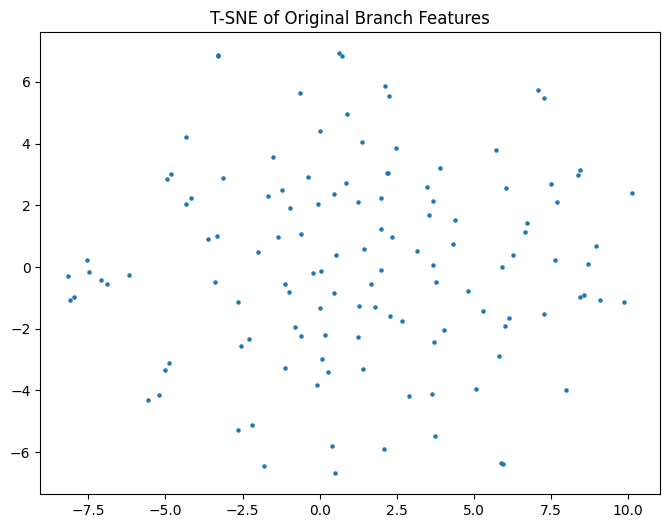

<Figure size 640x480 with 0 Axes>

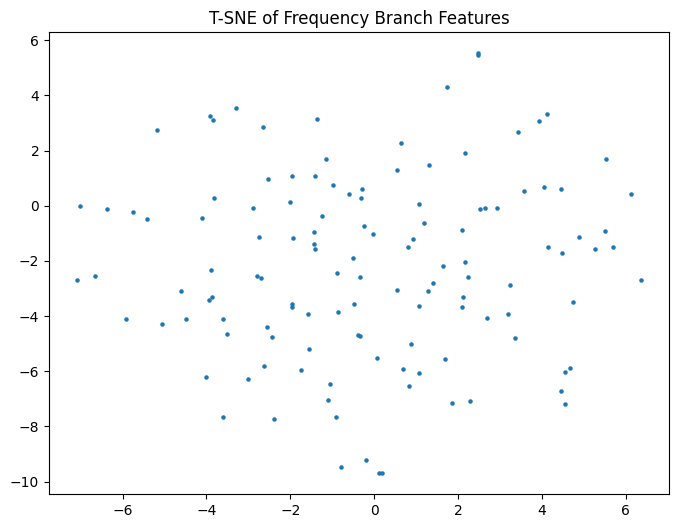

<Figure size 640x480 with 0 Axes>

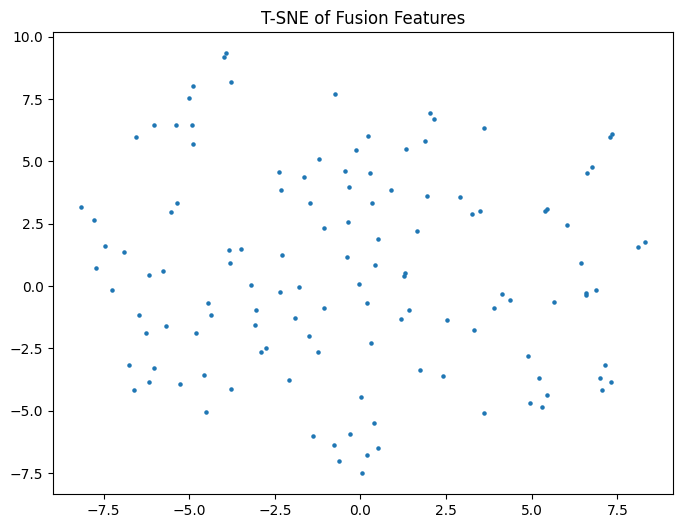

<Figure size 640x480 with 0 Axes>

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 从捕获的特征中提取 numpy 数组
original_features = features['original_branch'].cpu().numpy()
frequency_features = features['frequency_branch'].cpu().numpy()
fusion_features = features['fusion'].cpu().numpy()

# 使用T-SNE进行降维
tsne = TSNE(n_components=2, random_state=42)

# 分别对两个分支的特征以及融合后的特征进行T-SNE处理
original_features_tsne = tsne.fit_transform(original_features)
frequency_features_tsne = tsne.fit_transform(frequency_features)
fusion_features_tsne = tsne.fit_transform(fusion_features)

# 可视化
def plot_tsne(features, title, name):
    plt.figure(figsize=(8, 6))
    plt.scatter(features[:, 0], features[:, 1], s=5, cmap='viridis')
    plt.title(title)
    plt.show()
    plt.savefig(name)

# 可视化原始图像分支特征
plot_tsne(original_features_tsne, "T-SNE of Original Branch Features",
 "T-SNE of Original Branch Features.png")
# 可视化频域图像分支特征
plot_tsne(frequency_features_tsne, "T-SNE of Frequency Branch Features",
 "T-SNE of Frequency Branch Features.png")
# 可视化融合后的特征
plot_tsne(fusion_features_tsne, "T-SNE of Fusion Features",
 "T-SNE of Fusion Features.png")
